In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy.constants as co
import scipy.stats as ss
import itertools
import pickle
from scipy import signal

Get The Flux Spectrum
=====================

In [2]:
# constants

# time for fast neutron to scatter enough times to fall to thermal energies
t_slow = 2.7e-6 # sec (2.7 us)

# time for thermal neutron to capture or decay (or otherwise be removed from consideration)
t_stop = 1e-5 # sec (100 us)

# approx room temperature
T = 298 # K (25 C)

# physical constants
k = co.physical_constants['Boltzmann constant in eV/K'][0] # Boltzmann constant in eV/K
B = 1/k/T # thermal energy constant [1/eV]
m_n = co.physical_constants['neutron mass energy equivalent in MeV'][0]*1e6 # neutron mass in eV
yr = 365*24*3600 # seconds per year
sealevel = 4/3600 # accepted neutron flux at sea level [cm^-2 s^-1]

In [3]:
# functions

def integrate_df(df):
    # (left-sided rectangular integral)
    dE = -df['E'].diff(periods = -1)
    dE.iat[-1] = dE.iat[-2]
    A = df['spec']*dE
    return A.sum()

def maxwell(E, B):
    # height of Maxwell distribution for energy E (eV) and temperature T (K) related to B via B = 1/kT
    return 2*B*np.sqrt(B*E/np.pi)*np.exp(-B*E)

In [4]:
# read in fast neutron flux spectrum (from reading_n_spectra.ipynb)
fast_flux_df = pd.read_pickle('data/FDF.txt') # 'E' in MeV, 'spec' in neutrons cm^-2 sec^-1 MeV^-1


#use numpy arrays
ff = np.asarray(fast_flux_df['E']);
ffspec = np.asarray(fast_flux_df['spec']);

In [5]:
# calculate flux level of fast neutrons
fast_flux = integrate_df(fast_flux_df)

In [6]:
#smooth the data
ffspec_smooth = signal.savgol_filter(ffspec, 501, 3) # window size 501, polynomial order 3

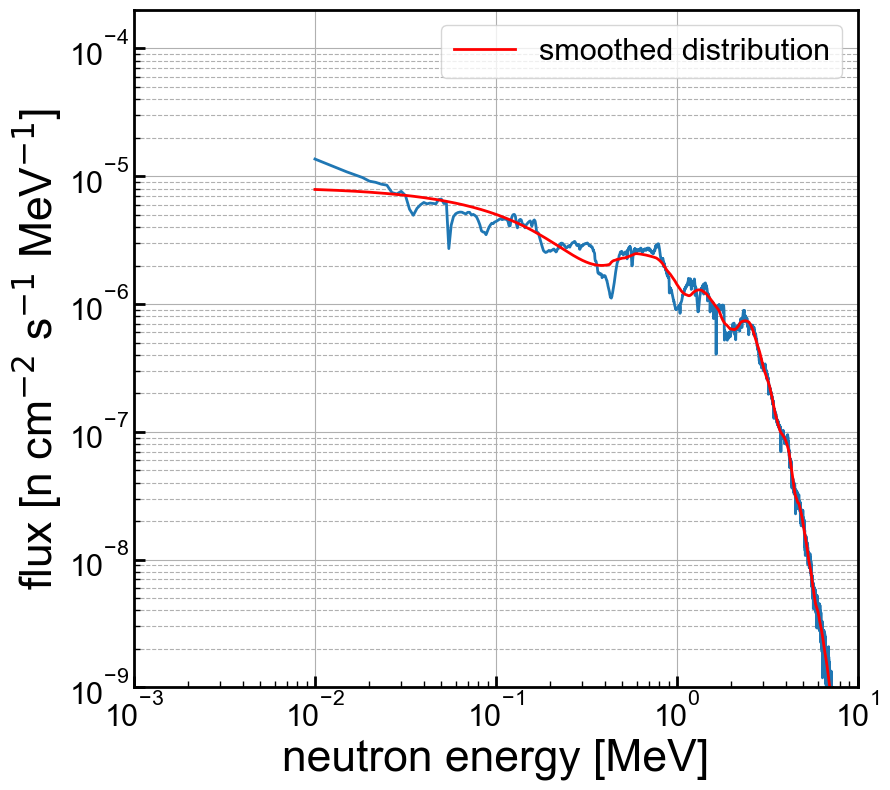

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#print(estring)
ax1.plot(ff, ffspec)
ax1.plot(ff, ffspec_smooth,color='r',label="smoothed distribution")


ymin = 1e-9
ymax = 2.0e-4

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-3, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [8]:
cutoff=0.3

ffhe = ff[ff>cutoff]
ffhespec = ffspec[ff>cutoff]

#smooth the data
ffhespec_smooth = signal.savgol_filter(ffhespec, 2001, 3) # window size 1001, polynomial order 3

ffle = ff[ff<=cutoff]
fflespec = ffspec[ff<=cutoff]
print(np.size(ffle))

#smooth the data
fflespec_smooth = signal.savgol_filter(fflespec, 75, 3) # window size 1001, polynomial order 3

175


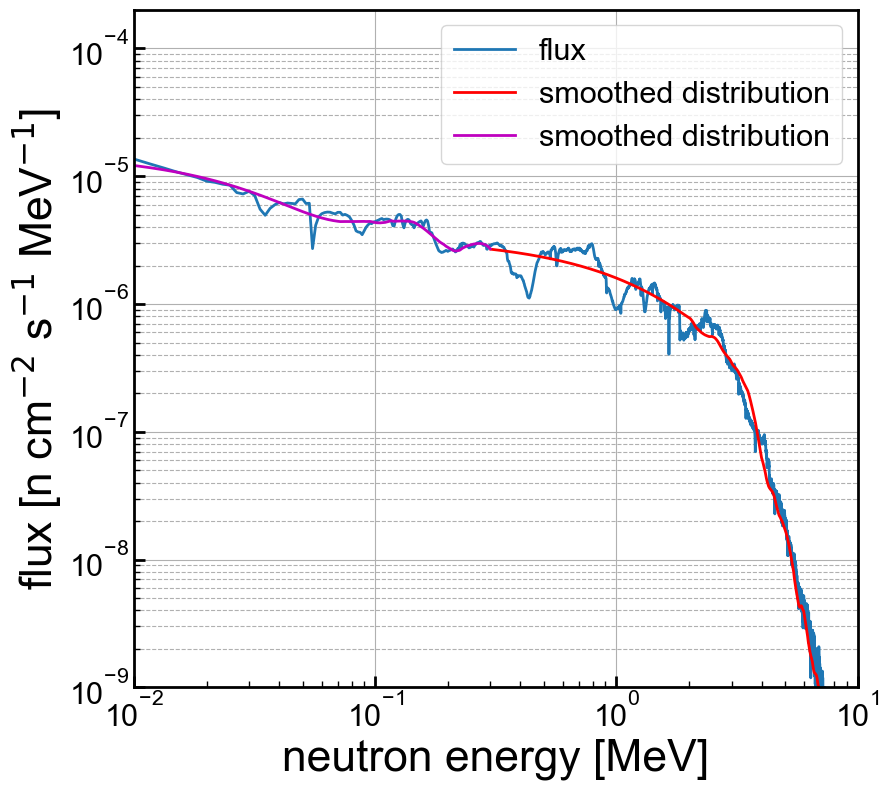

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#print(estring)
ax1.plot(ff, ffspec,label='flux')
ax1.plot(ffhe, ffhespec_smooth,color='r',label="smoothed distribution")
ax1.plot(ffle, fflespec_smooth,color='m',label="smoothed distribution")


ymin = 1e-9
ymax = 2.0e-4

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-2, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

Get the Cross Section Function
==============================

In [10]:
m_n = co.physical_constants['neutron mass energy equivalent in MeV'][0]*1e3 # neutron mass in keV
m_e = co.physical_constants['electron mass energy equivalent in MeV'][0]*1e3

print("Neutron Mass: {} keV".format(m_n))
print("Electron Mass: {} keV".format(m_e))

Neutron Mass: 939565.4205199999 keV
Electron Mass: 510.99895 keV


In [11]:
def Emax(En): #En in keV; returns maximum recoil energy for neutron energy
    return (4*m_e*m_n*En)/(m_e+m_n)**2

def Enmin(Er): #recoil energy in keV; returns minimum neutron energy to give that recoil energy
    return (Er*(m_e+m_n)**2)/(4*m_e*m_n)

In [12]:
print(Emax(1000))
print(Enmin(2.0))

2.1731049725220037
920.34210279262


In [13]:
#constants for calcs, first in SI units
gn = co.physical_constants['neutron gyromag. ratio'][0] #default is s^-1 T^-1; CGS is s^-1 Gauss^-1
mub = co.physical_constants['Bohr magneton'][0] #default is J T^-1
hbar = co.physical_constants['reduced Planck constant'][0] #default in J s

In [14]:
#convert to CGS
#see https://en.wikipedia.org/wiki/Centimetre%E2%80%93gram%E2%80%93second_system_of_units
m_n_CGS = co.physical_constants['neutron mass'][0]*1e3 #convert to grams
gn_CGS = gn/1e4
mub_CGS = mub*1e3
hbar_CGS = hbar*1e7

In [15]:
print('Neutron mass: {} g'.format(m_n_CGS))
print('Neutron gyromagnetic ratio: {} s^-1 Gauss^-1 '.format(gn_CGS))
print('Bohr magneton: {} erg Gauss^-1 '.format(mub_CGS))
print('hbar: {} erg s '.format(hbar_CGS))

Neutron mass: 1.67492749804e-24 g
Neutron gyromagnetic ratio: 18324.7171 s^-1 Gauss^-1 
Bohr magneton: 9.2740100783e-21 erg Gauss^-1 
hbar: 1.054571817e-27 erg s 


In [16]:
barnincm2 = 1e-24

In [17]:
sigtot = 8*np.pi*m_n_CGS**2*gn_CGS**2*mub_CGS**2/hbar_CGS**2
print('Total cross section: {} barns'.format(sigtot/barnincm2))

Total cross section: 1.8310038087245937 barns


In [18]:
def dsigdEr(En,Er):
    if(Er<Emax(En)):
      return 8*np.pi*m_n_CGS**2*gn_CGS**2*mub_CGS**2/hbar_CGS**2/Emax(En)
    else: 
      return 0

In [19]:
print(dsigdEr(1000,1)/barnincm2)

0.8425749477714446


Differential Rates
==================

In [20]:
#some other constants
#molar mass of silicon
msi = 28.0855 #g
NA = co.physical_constants['Avogadro constant'][0]

In [21]:
print(NA)

6.02214076e+23


In [22]:
etot = np.concatenate((ffle,ffhe))
etot = np.unique(etot)
etotspec = np.zeros((np.size(etot),),dtype=np.float64)
print(np.size(etot),np.size(etotspec))


6000 6000


In [23]:
etotspec[(etot<=ffle[-1])] = fflespec_smooth

In [24]:
etotspec[(etot>ffle[-1])] = ffhespec_smooth

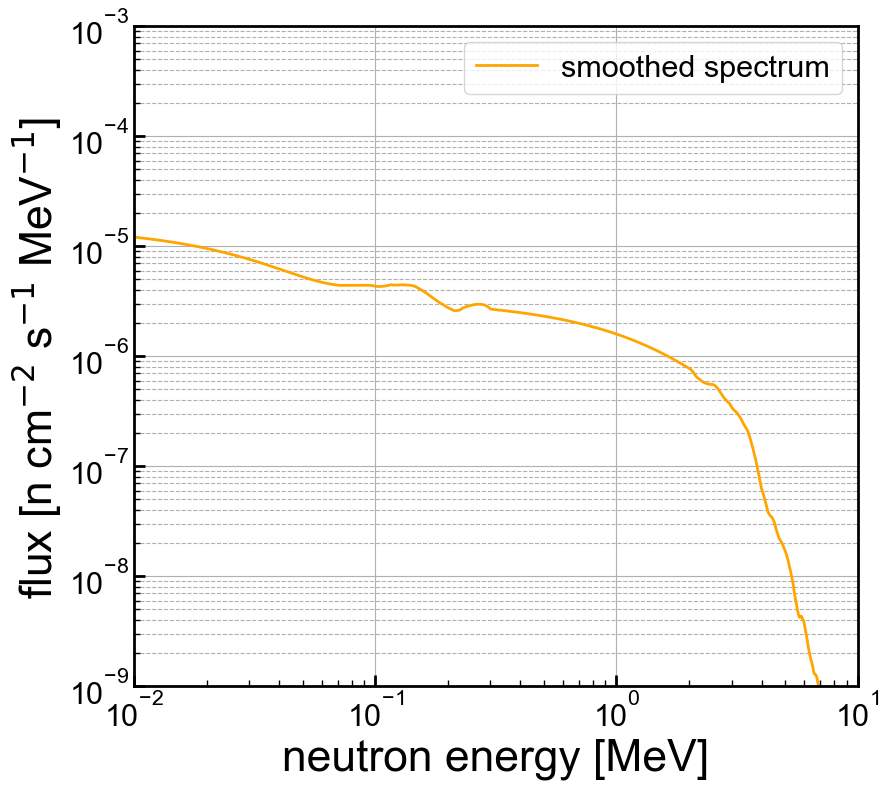

In [25]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(etot, etotspec,color='orange',label="smoothed spectrum")



ymin = 1e-9
ymax = 1e-3

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-2, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [26]:
from scipy import optimize
from scipy.interpolate import CubicSpline


flux = CubicSpline(etot, etotspec*(60*60*24))

ol = optimize.root(flux, 5, method='hybr')
print(ol.x[0])

def realflux(En):
    if En>=ol.x[0]:
        return 0
    
    return flux(En)

print(realflux(0.0001))
print(realflux(0.001))
print(realflux(0.01))
print(realflux(0.1))
print(realflux(1))
print(realflux(10))
print(realflux(100))
print(realflux(1000))

9.855459988002398
1.3279692551317055
1.2999419215661245
1.0487702366077158
0.3751741181954933
0.137864123257127
0
0
0


In [27]:
from scipy import integrate
def dru(Er):
    f = lambda x,y: 14*(NA/msi)*realflux(x)*dsigdEr(x*1000,y)
    return integrate.quad_vec(f,Enmin(Er)/1000,100,args=(Er,))

In [28]:
energy=1
print(dru(energy))
print(Enmin(energy)/1000)

(0.05846356680356157, 7.294650566877073e-11)
0.46017105139631004


/var/folders/qs/y0dxxqrn4rd_pc96p6hnq51w0000gn/T/ipykernel_53375/3395280047.py:3: RuntimeWarning: overflow encountered in scalar multiply
  f = lambda x,y: 14*(NA/msi)*realflux(x)*dsigdEr(x*1000,y)


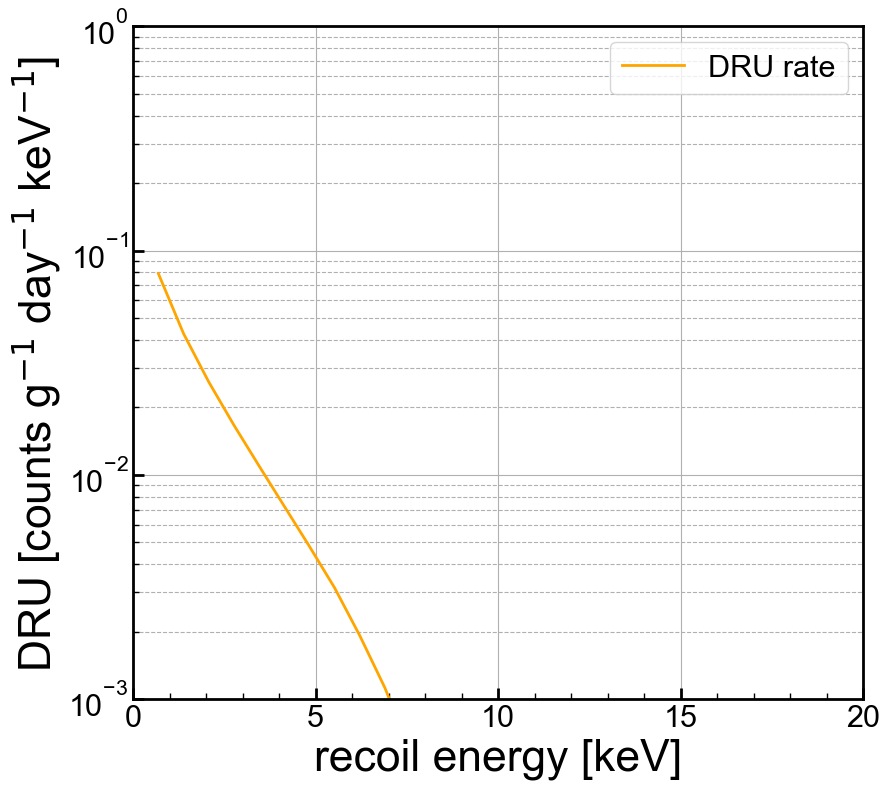

In [37]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

erange = np.linspace(0.0,20.0,30)
druvec = np.ones(np.shape(erange))
for i,e in enumerate(erange):
    druvec[i] = dru(e)[0]


#print(estring)
ax1.plot(erange, druvec,color='orange',label="DRU rate")



ymin = 1e-3
ymax = 1

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

ax1.set_yscale('log')
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0.0, 20) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]')
ax1.set_ylabel('DRU [counts g$^{-1}$ day$^{-1}$ keV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
plt.savefig('figures/ne_bknd_gday.png')
plt.show()

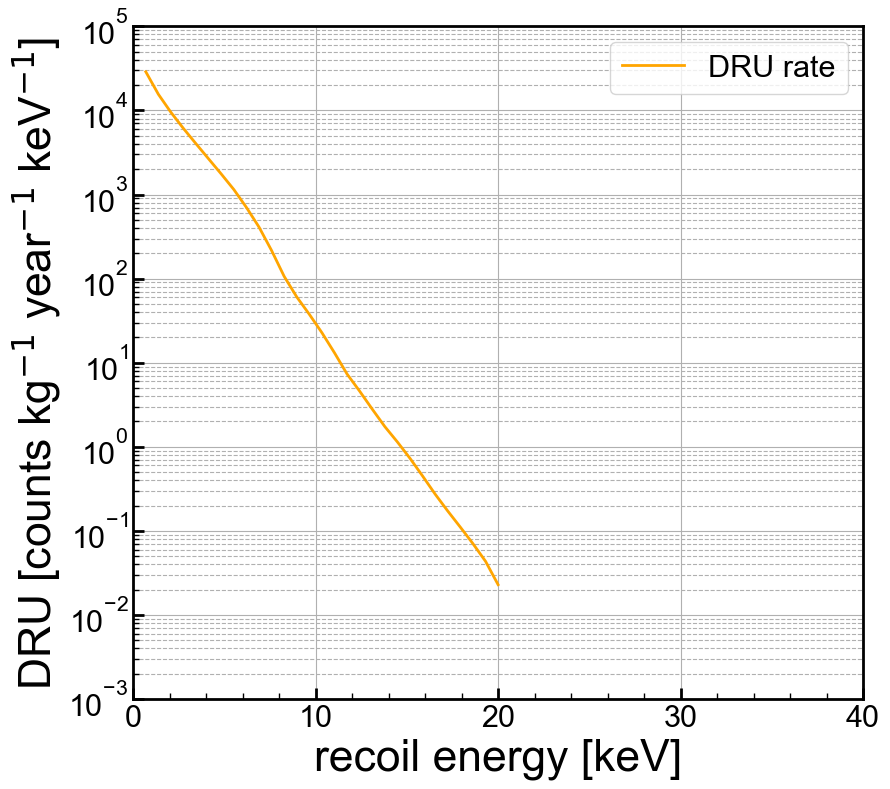

In [41]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#print(estring)
ax1.plot(erange, 1000*365*druvec,color='orange',label="DRU rate")



ymin = 1e-3
ymax = 100000

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

ax1.set_yscale('log')
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_xscale('log')
ax1.set_xlim(0.0, 40) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]')
ax1.set_ylabel('DRU [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.savefig('figures/ne_bknd_kgyr.png')
plt.show()

/var/folders/qs/y0dxxqrn4rd_pc96p6hnq51w0000gn/T/ipykernel_53375/3395280047.py:3: RuntimeWarning: overflow encountered in scalar multiply
  f = lambda x,y: 14*(NA/msi)*realflux(x)*dsigdEr(x*1000,y)
/var/folders/qs/y0dxxqrn4rd_pc96p6hnq51w0000gn/T/ipykernel_53375/1794960303.py:26: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0.0, 40)


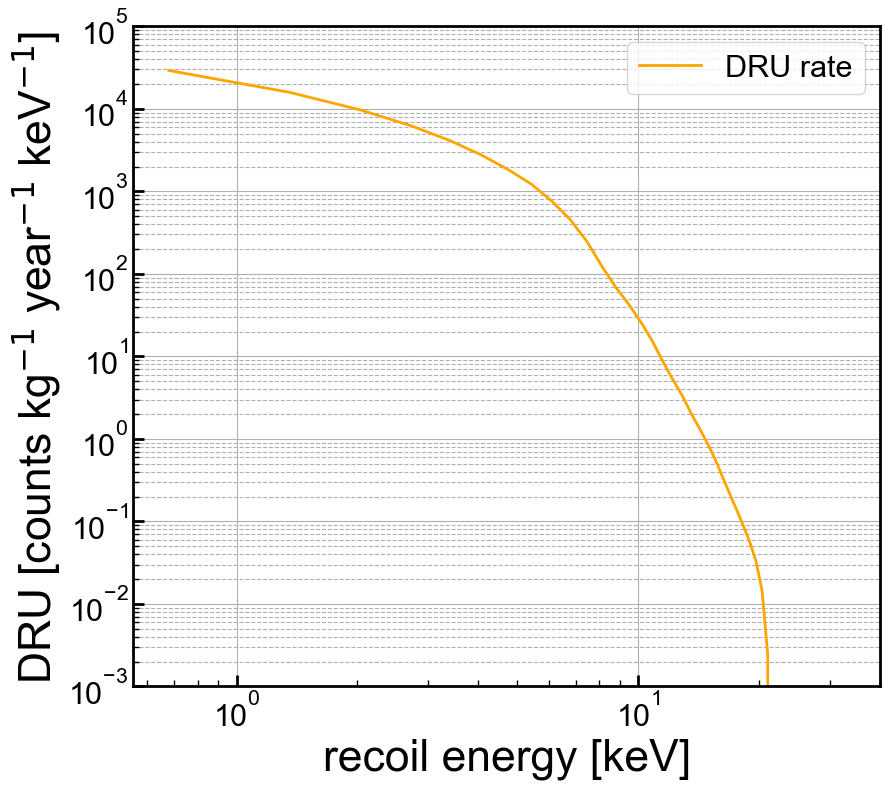

In [43]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

erange = np.linspace(0.0,40.0,60)
druvec = np.ones(np.shape(erange))
for i,e in enumerate(erange):
    druvec[i] = dru(e)[0]

#print(estring)
ax1.plot(erange, 1000*365*druvec,color='orange',label="DRU rate")



ymin = 1e-3
ymax = 100000

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

ax1.set_yscale('log')
plt.grid()
#ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.set_xlim(0.0, 40) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]')
ax1.set_ylabel('DRU [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.savefig('figures/ne_bknd_kgyr_logx.png')
plt.show()

In [31]:
#create a yield model
import lindhard as lind

#lindhard
lpar = lind.getLindhardPars('Si',True) #use the "calculated" value of k
print(lpar)
#ylind = lind.getLindhard(lpar)
ylind = lind.getLindhardSi_k(0.15)
ylindv = np.vectorize(ylind) #careful, this expects inputs in eV

{'Z': 14, 'A': 28, 'k': 0.14600172346755985, 'a': 3.0, 'b': 0.15, 'c': 0.7, 'd': 0.6}


In [32]:
print(ylindv([10,100]))

[0.11498363 0.15659163]


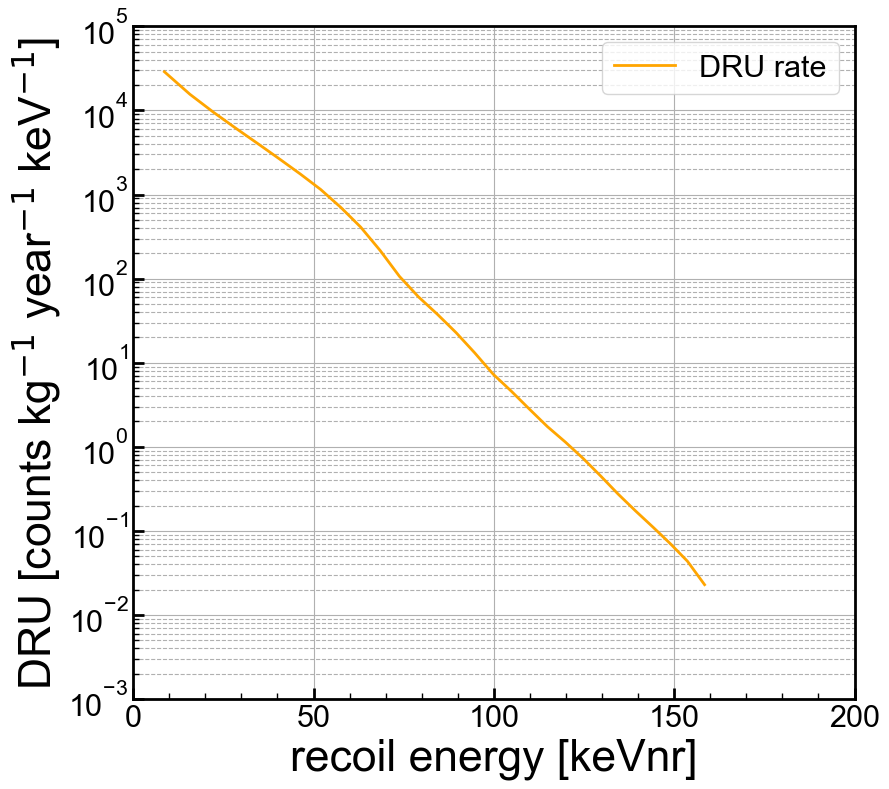

In [35]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

Enr=erange[erange>0]/ylindv(erange[erange>0])


#print(estring)
ax1.plot(erange[erange>0]/ylindv(erange[erange>0]), 1000*365*druvec[erange>0],color='orange',label="DRU rate")



ymin = 1e-3
ymax = 100000

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

ax1.set_yscale('log')
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0.0, 200) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keVnr]')
ax1.set_ylabel('DRU [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()